# Denoising Project
*Ian Malone*

### Project Description

The purpose of this project is to design and evaluate the performance of a machine learning algorithm using the normalized LMS algorithm (or one of its variants) that will clean the desired input (speech plus noise) from the machine noise (input). This is an example of the interference canceling problem explained below.

Speech data is collected in a noisy room (loud vacuum cleaner) by two microphones: one on a table that captures speech with the vacuum cleaner noise (d(n)) and the other very close to the vacuum cleaner (n(n)) that basically has no speech. Even if you listen to d(n), the speech is barely audible, and the message is not understandable. The goal is to denoise d(n) and be able to understand the speech. It is suggested to use the signal n(n) as the input to the LMS algorithm and use d(n) as the desired response. 

### Project Steps

Start with a 2-tap filter:

 - Plots of the performance surface contours for the two weights filter case.
 - Plot the weight tracks
 - Plot the learning curve and interpret it.
 - Estimate the frequency response from the desired signal to the error when the filter is adapted.
 - Estimate the SNR improvement in dB by: 
    $ERLE=10\log(\frac{E[d^{2}]}{E[e^{2}]})$
    
Increase the filter order based on an analysis of performance. Explain your choice for the filter order.

 - Estimate again the frequency response from the desired signal to the error.
 - Compute the SNR improvement in dB
 - Evaluate the filter performance as a function of the stepsize.
 - Estimate the misadjustment.
 - Comment on the results obtained and address issues related to the convergence of the algorithm in nonstationary environments.
 
You can use a FIR filter, a gamma filter or the KLMS to compare performance. 

### Project Implementation

In [27]:
# Import libraries

import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [29]:
# The .mat file contains two channels with data labeled as desired (d) and input (n). 

filepath = 'C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Classes\\ML Time Series\\Projects\\Project1\\project1.mat'
mat_data = scipy.io.loadmat(filepath)
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'fs', 'primary', 'reference'])


In [314]:
fs = mat_data['fs']
# u is mostly noise input
# d is speech + noise desired
# error will be denoised speech

u = np.asarray(mat_data['primary'])[0,:]
d = np.asarray(mat_data['reference'])[0,:]

In [552]:
len(u)

70000

Text(0.5, 1.0, 'Primary and Reference Signals')

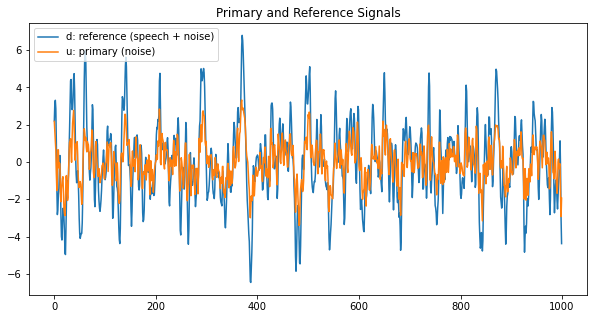

In [553]:
plt.figure(figsize=(10,5))

plt.plot(d[:1000], label='d: reference (speech + noise)')
plt.plot(u[:1000], label='u: primary (noise)')

plt.legend(loc="upper left")
plt.title('Primary and Reference Signals')

In [515]:
class NLMS():
    
    def __init__(self, step_size=0.4, order=2):
        self.step_size = step_size
        self.order = order
        
    def learn(self, u, d):

        # initialization
        w = np.random.rand(self.order)
        e = np.zeros(len(u))
        w_trk = np.zeros((len(u), self.order))

        # computation
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            norm = ((np.linalg.norm(u[i:i+self.order])) ** 2)+0.1
            w = w + (self.step_size * e[i] * u[i])/norm   #normalize the step by the power of the input
            f[i] = y
            #update tracks matrix
        return f, w, e


class GaussianKernel:
    def kernel(self, a, b):
        numer = (np.linalg.norm(a - b)) ** 2
        denom = (2 * self.sigma ** 2)
        return np.exp(-1 * (numer / denom))
    
    
class KLMS(GaussianKernel):
    
    def __init__(self, step_size=0.4, sigma=1, order=3): 
        self.step_size = step_size
        self.sigma = sigma
        self.order = order
       
    
    def learn(self, input_signal, desired_signal):
        estimates = np.zeros(len(input_signal))
        coefficients = np.zeros(len(input_signal))
        errors = np.zeros(len(input_signal))
        coefficients[0] = self.step_size * desired_signal[0]

        # computation
        for i in range(1, len(input_signal)-self.order):
            estimates[i-1] = 0
            for j in range(i-1):
                partial_sum = coefficients[j] * self.kernel(input_signal[i:i+(self.order-1)], input_signal[j:j+(self.order-1)])
                estimates[i-1] += partial_sum                 

            errors[i] = desired_signal[i+self.order] - estimates[i-1]
            coefficients[i] = self.step_size * errors[i]
        
        return estimates, coefficients, errors

#### Test the NLMS and KLMS on a Noisy Sine Wave

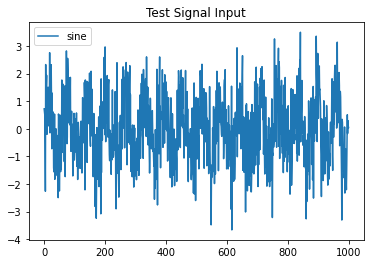

In [544]:
time = np.arange(0,100,0.1)
noisy_sine = np.sin(time)+np.random.normal(size=len(time))
plt.plot(amplitude, label='sine')

plt.title('Test Signal Input (Noisy Sine)')
plt.legend(loc='upper left')

In [545]:
klms_test = KLMS(step_size=0.2, sigma=2, order=3)

In [546]:
f,w,e = klms_test.learn(noisy_sine,noisy_sine)

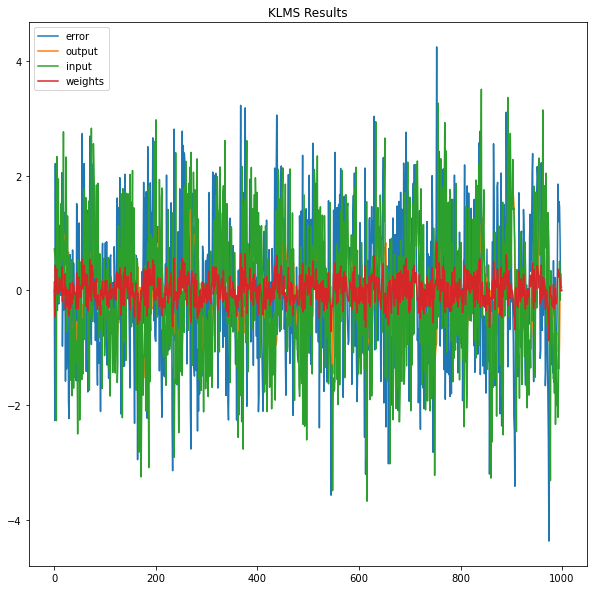

In [547]:
plt.figure(figsize=(10,10))

plt.plot(e, label='error')
plt.plot(f, label='output')
plt.plot(noisy_sine, label='input')
plt.plot(w, label='weights')

plt.title('KLMS Results')
plt.legend(loc="upper left")

In [548]:
nlms_test = NLMS(step_size=0.8, order=2)

In [549]:
f2,w2,e2 = nlms_test.learn(noisy_sine,noisy_sine)

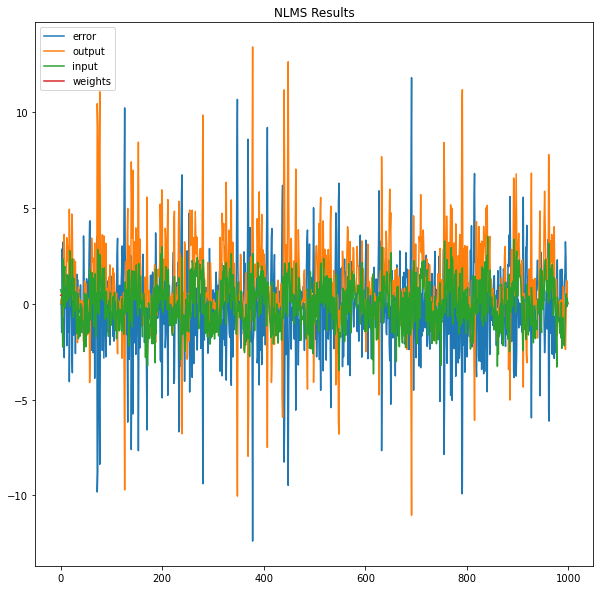

In [551]:
plt.figure(figsize=(10,10))

plt.plot(e2, label='error')
plt.plot(f2, label='output')
plt.plot(noisy_sine, label='input')
plt.plot(w2, label='weights')

plt.title('NLMS Results')
plt.legend(loc="upper left")

In [494]:
klms_test = KLMS(step_size=0.4, sigma=1, order=3)

In [495]:
f,w,e = klms_test.learn(u[:20000],d[:20000])

In [537]:
nlms_test = NLMS(step_size=0.4, order=3)

In [538]:
f2,w2,e2 = nlms_test.learn(u[:20000],d[:20000])

(-10.0, 10.0)

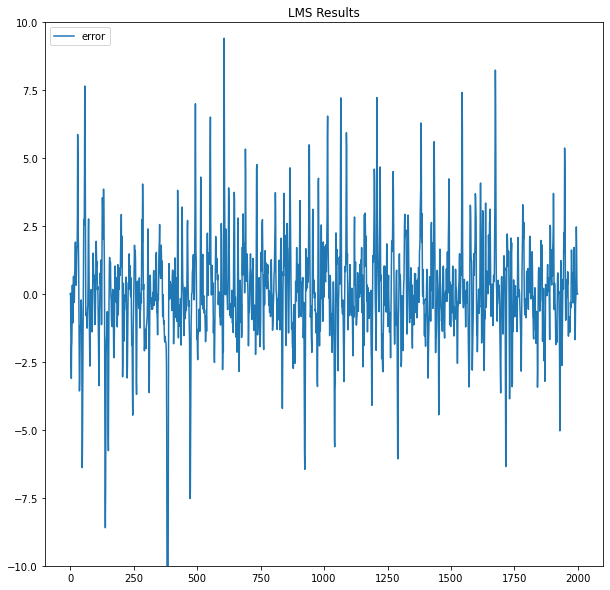

In [539]:
plt.figure(figsize=(10,10))

plt.plot(e2, label='error')
plt.plot(f2, label='output')
plt.plot(amplitude, label='input')
plt.plot(w2, label='weights')

plt.title('NLMS Results')
plt.legend(loc="upper left")
plt.ylim([-10,10])

(-10.0, 10.0)

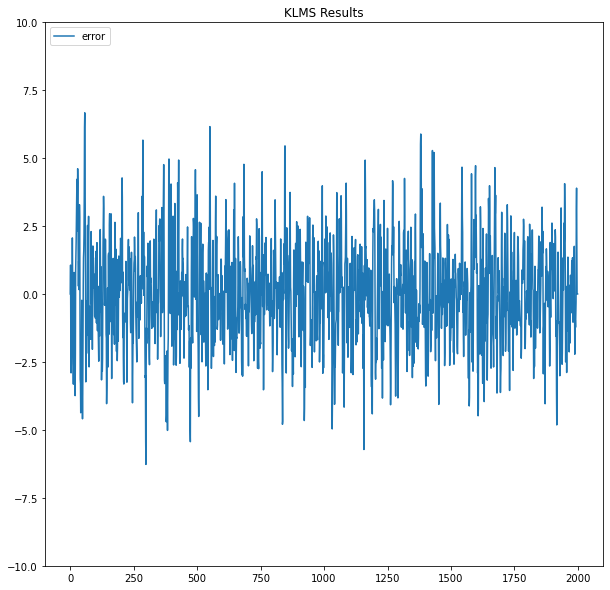

In [540]:
plt.figure(figsize=(10,10))

plt.plot(e, label='error')
plt.plot(f, label='output')
plt.plot(amplitude, label='input')
plt.plot(w, label='weights')

plt.title('KLMS Results')
plt.legend(loc="upper left")
plt.ylim([-10,10])